In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy import mean
from numpy import std

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainingdata1data=pd.read_csv('/content/drive/My Drive/FML_Data/training1.csv')
trainingdata2data=pd.read_csv('/content/drive/My Drive/FML_Data/training2.csv')
testdata=pd.read_csv('/content/drive/My Drive/FML_Data/test.csv')

**DATA PREPROCESSING**

Fill in missing NaN values in our test data using an imputer.

In [ ]:
TotalTestData = testdata
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
TotalTestData = imputer.fit_transform(TotalTestData)
TotalTestData = pd.DataFrame(TotalTestData, columns = testdata.columns)

Separate training2data into respective confidence and label values so that imputing gives the most accurate values for each set. 4 sets get concatenated into one.

In [ ]:
DefSunnyTrainingData = trainingdata2data.loc[(trainingdata2data['confidence'] == 1) & (trainingdata2data['label'] == 1)]
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
DefSunnyTrainingData = imputer.fit_transform(DefSunnyTrainingData)
DefSunnyTrainingData = pd.DataFrame(DefSunnyTrainingData, columns = trainingdata2data.columns)

DefDarkTrainingData = trainingdata2data.loc[(trainingdata2data['confidence'] == 1) & (trainingdata2data['label'] == 0)]
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
DefDarkTrainingData = imputer.fit_transform(DefDarkTrainingData)
DefDarkTrainingData = pd.DataFrame(DefDarkTrainingData, columns = trainingdata2data.columns)

ProbSunnyTrainingData = trainingdata2data.loc[(trainingdata2data['confidence'] != 1) & (trainingdata2data['label'] == 1)]
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
ProbSunnyTrainingData = imputer.fit_transform(ProbSunnyTrainingData)
ProbSunnyTrainingData = pd.DataFrame(ProbSunnyTrainingData, columns= trainingdata2data.columns)

ProbDarkTrainingData = trainingdata2data.loc[(trainingdata2data['confidence'] != 1) & (trainingdata2data['label'] == 0)]
imputer = SimpleImputer(fill_value=np.nan, strategy='mean')
ProbDarkTrainingData = imputer.fit_transform(ProbDarkTrainingData)
ProbDarkTrainingData = pd.DataFrame(ProbDarkTrainingData, columns = trainingdata2data.columns)

Preprocessedtraining2data = pd.concat([DefSunnyTrainingData, DefDarkTrainingData, ProbSunnyTrainingData, ProbDarkTrainingData])

TotalTrainingData = pd.concat([trainingdata1data, Preprocessedtraining2data])
#print(trainingdata1data.shape)
#print(Preprocessedtraining2data.shape)
#print(TotalTrainingData.shape)

**CHI-SQUARED CASES**

Chi2 cases appear before other classifiers as Chi2 cannot take negative parameters and therefore feature selection must occur before normalizing the data. This violates the itegrity of their choice selection. Chi2 therefore not used for test label predictions. Had idea to include ||x|| modulus for all data points to enable scaling to happen prior to feature selection. Could not work out how to implement in code.

Case: Total training data Perceptron

In [ ]:
trainingLabels=TotalTrainingData["label"]

chiScaler = StandardScaler()

WrapTrainingData = TotalTrainingData.loc[:, TotalTrainingData.columns != 'label']
ClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

test = SelectKBest(score_func=chi2, k=1400)
chi2TrainingData = test.fit_transform(ClassificationTrainingData,trainingLabels) #fit chi2 with data above

chi2TrainingData = chiScaler.fit_transform(chi2TrainingData) #now normalize using scaler defined above

chi2TrainingData = pd.DataFrame(chi2TrainingData)

chi2Model = Perceptron(eta0=0.0001)
chi2Model = Perceptron(max_iter=100)
chi2Model.fit(chi2TrainingData, trainingLabels) #fit Perceptron to chi2 data above

cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
scores = cross_val_score(chi2Model, chi2TrainingData, trainingLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.70595 (0.11490)


Case: 100% confidence data Perceptron

In [ ]:
chiScaler1 = StandardScaler()

chi2ConfidentTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1] #only 100% confidence

WrapTrainingData = chi2ConfidentTrainingData.loc[:, TotalTrainingData.columns != 'label']
ChiClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)] #labels for confidence
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

chosenTest = SelectKBest(score_func=chi2, k=600)
chi2TrainingData1 = chosenTest.fit_transform(ChiClassificationTrainingData,confidentLabels) #fit and transform chi2 using data above

chi2TrainingData1 = chiScaler1.fit_transform(chi2TrainingData1)

chi2TrainingData1 = pd.DataFrame(chi2TrainingData1)

chi2ConfidentModel = Perceptron(eta0=0.05)
chi2ConfidentModel = Perceptron(max_iter=100)
chi2ConfidentModel.fit(chi2TrainingData1, confidentLabels) #fit chi2 data to our perceptron

cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
scores = cross_val_score(chi2ConfidentModel, chi2TrainingData1, confidentLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

chi2TestData = chosenTest.transform(TotalTestData)

chi2TestData = chiScaler1.fit_transform(chi2TestData)

chi2TestData = pd.DataFrame(chi2TestData)

chi2Predictions = chi2ConfidentModel.predict(chi2TestData)

chi2Predictions = pd.DataFrame(chi2Predictions)

Mean Accuracy: 0.79617 (0.10058)


Case: Total training data Logistic Regression

Accuracy:  0.7219917012448133


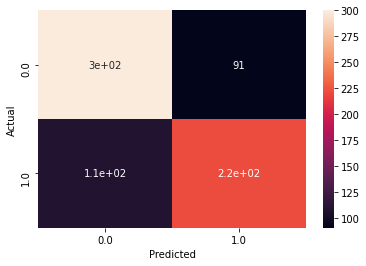

In [ ]:
trainingLabels=TotalTrainingData["label"]

chiScaler2 = StandardScaler()

WrapTrainingData = TotalTrainingData.loc[:, TotalTrainingData.columns != 'label']
ClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

test = SelectKBest(score_func=chi2, k=600)
chi2TrainingData2 = test.fit_transform(ClassificationTrainingData,trainingLabels)

chi2TrainingData2 = chiScaler2.fit_transform(chi2TrainingData2) #now normalize using scaler defined above

chi2TrainingData2 = pd.DataFrame(chi2TrainingData2)

X = chi2TrainingData2
y = trainingLabels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) #80/20 train test split

logistic_regression= LogisticRegression(max_iter=100000)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=False)
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
plt.show()

Case: 100% confidence data Logistic Regression

Accuracy:  0.7927461139896373


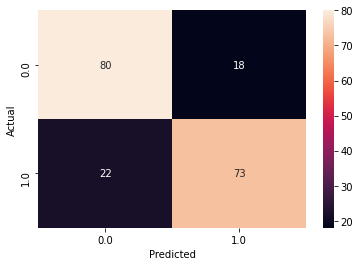

In [ ]:
chiScaler3 = StandardScaler()

CertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

WrapTrainingData1 = CertainTrainingData.loc[:, CertainTrainingData.columns != 'label']
ConfidentTrainingData = WrapTrainingData1.loc[:, WrapTrainingData1.columns != 'confidence']

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

test = SelectKBest(score_func=chi2, k=600)
chi2TrainingData3 = test.fit_transform(ConfidentTrainingData,confidentLabels)

chi2TrainingData3 = chiScaler3.fit_transform(chi2TrainingData3) #normalize using scaler defined above

chi2TrainingData3= pd.DataFrame(chi2TrainingData3)

X = chi2TrainingData3
y = confidentLabels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) #randomstate=0 increases accuracy to normal mode which is random, suggests overfitting

logistic_regression= LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
plt.show()

Scale Data Before **RUNNING CLASSIFIERS**. Test data transformed using same scaler defined for training data.

In [ ]:
ss = StandardScaler()
TotalTrainingData.iloc[:,0:4608] = ss.fit_transform(TotalTrainingData.iloc[:,0:4608])
TotalTestData = ss.transform(TotalTestData)


Scaler creates uniform variance for all features

In [ ]:
print(TotalTrainingData.var(ddof=0))
print(TotalTestData.var(ddof=0))

CNNs          1.000000
CNNs.1        1.000000
CNNs.2        1.000000
CNNs.3        1.000000
CNNs.4        1.000000
                ...   
GIST.509      1.000000
GIST.510      1.000000
GIST.511      1.000000
label         0.248380
confidence    0.022561
Length: 4610, dtype: float64
0.9532073521964011


**RUNNING CLASSIFIERS**

***Perceptron***

Case: Total training data

In [ ]:
trainingLabels=TotalTrainingData["label"]

WrapTrainingData = TotalTrainingData.loc[:, TotalTrainingData.columns != 'label']
ClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

model = Perceptron(eta0=0.01)
model = Perceptron(max_iter=100)

model.fit(ClassificationTrainingData, trainingLabels) #fit using data and labels

cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
scores = cross_val_score(model, ClassificationTrainingData, trainingLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

testPredictionz = model.predict(TotalTestData)
testPredictionz = pd.DataFrame(testPredictionz)

Mean Accuracy: 0.75176 (0.11044)


Case: Total training data post PCA

In [ ]:
pca = PCA(0.8)
pcaTrainingData = pca.fit_transform(TotalTrainingData)
pcaDataFrame = pd.DataFrame(pcaTrainingData)

trainingLabels2=TotalTrainingData["label"]

pcaModel = Perceptron(eta0=0.001)
pcaModel = Perceptron(max_iter=100)
pcaModel.fit(pcaDataFrame, trainingLabels)
cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
scores = cross_val_score(pcaModel, pcaDataFrame, trainingLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.74097 (0.11218)


Case: 100% confidence data

In [ ]:
CertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

WrapTrainingData1 = CertainTrainingData.loc[:, CertainTrainingData.columns != 'label']
ConfidentTrainingData = WrapTrainingData1.loc[:, WrapTrainingData1.columns != 'confidence']

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

confidentModel = Perceptron(eta0=0.0001)
confidentModel = Perceptron(max_iter=100)
confidentModel.fit(ConfidentTrainingData, confidentLabels)
cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
scores = cross_val_score(confidentModel, ConfidentTrainingData, confidentLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

testPredictions = confidentModel.predict(TotalTestData)
testPredictions = pd.DataFrame(testPredictions)
testPredictions

Mean Accuracy: 0.83014 (0.10189)


,0
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
2162,0.0
2163,0.0
2164,0.0
2165,1.0


Case: 100% confidence data post PCA

In [ ]:
pca1 = PCA(0.8)

pcaTrainingData1 = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

WrapTrainingData1 = pcaTrainingData1.loc[:, pcaTrainingData1.columns != 'label']
ConfidentTrainingData = WrapTrainingData1.loc[:, WrapTrainingData1.columns != 'confidence']

pcaConfidentData = pca1.fit_transform(ConfidentTrainingData) #transform data using pca
pcaConfidentDataFrame = pd.DataFrame(pcaConfidentData)

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

pcaConfidentModel = Perceptron(eta0=0.001)
pcaConfidentModel = Perceptron(max_iter=100)
pcaConfidentModel.fit(pcaConfidentDataFrame, confidentLabels) #fitt model with pca data transformed above
cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
scores = cross_val_score(pcaConfidentModel, pcaConfidentDataFrame, confidentLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

pcaTotalTestData = pca1.transform(TotalTestData)
pcaTotalTestData = pd.DataFrame(pcaTotalTestData)

chosenTestPredictions = pcaConfidentModel.predict(pcaTotalTestData)
chosenTestPredictions = pd.DataFrame(chosenTestPredictions).to_csv("/content/drive/My Drive/FML_Data/predictions.csv",header=['prediction'],index=None)

Mean Accuracy: 0.80283 (0.10623)


Case: 66% confidence data

In [ ]:
UncertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] != 1]

WrapTrainingData2 = UncertainTrainingData.loc[:, UncertainTrainingData.columns != 'label']
UnConfidentTrainingData = WrapTrainingData2.loc[:, WrapTrainingData2.columns != 'confidence']

wrapUnconfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] != 1)]
dfunconfidentLabels = wrapUnconfidentLabels.iloc[:,4608:4610]
del dfunconfidentLabels['confidence']
unconfidentLabels = dfunconfidentLabels["label"]

unconfidentModel = Perceptron(eta0=0.01)
unconfidentModel = Perceptron(max_iter=100)
unconfidentModel.fit(UnConfidentTrainingData, unconfidentLabels)
cv = RepeatedStratifiedKFold(n_splits = 177, n_repeats = 5, random_state=1)
scores = cross_val_score(unconfidentModel, UnConfidentTrainingData, unconfidentLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.75758 (0.11635)


Case: 66% confidence data post PCA

In [ ]:
pca2 = PCA(0.8)

pcaTrainingData2 = TotalTrainingData.loc[TotalTrainingData['confidence'] != 1]

pcaUnConfidentData = pca2.fit_transform(pcaTrainingData2)
pcaUnConfidentDataFrame = pd.DataFrame(pcaUnConfidentData)

wrapUnconfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] != 1)]
dfunconfidentLabels = wrapUnconfidentLabels.iloc[:,4608:4610]
del dfunconfidentLabels['confidence']
unconfidentLabels = dfunconfidentLabels["label"]

pcaUnconfidentModel = Perceptron(eta0=0.0001)
pcaUnconfidentModel = Perceptron(max_iter=100)
pcaUnconfidentModel.fit(pcaUnConfidentDataFrame, unconfidentLabels)
cv = RepeatedStratifiedKFold(n_splits = 177, n_repeats = 5, random_state=1)
scores = cross_val_score(pcaUnconfidentModel, pcaUnConfidentDataFrame, unconfidentLabels, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.5f (%.5f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.73059 (0.11495)


***Logistic Regression***

Case: Total Training Data


Accuracy:  0.7800829875518672


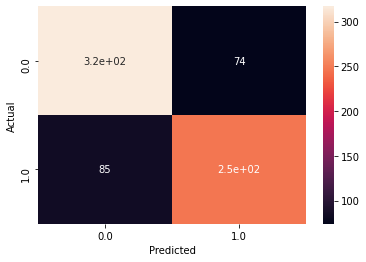

In [ ]:
trainingLabels=TotalTrainingData["label"]

X = TotalTrainingData.iloc[:,0:4608]
y = trainingLabels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

logistic_regression= LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
plt.show()

LRtestPredictionz = logistic_regression.predict(TotalTestData)
LRtestPredictionz = pd.DataFrame(LRtestPredictionz)

Case: 100% confidence data

Accuracy:  0.8497409326424871


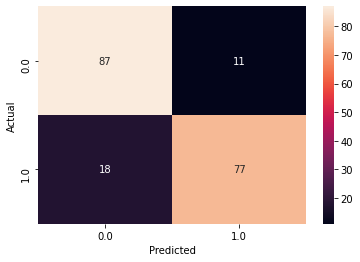

In [ ]:
CertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

WrapTrainingData1 = CertainTrainingData.loc[:, CertainTrainingData.columns != 'label']
ConfidentTrainingData = WrapTrainingData1.loc[:, WrapTrainingData1.columns != 'confidence']

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

X = ConfidentTrainingData
y = confidentLabels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) #randomstate=0 increases accuracy to normal mode which is random, suggests overfitting

logistic_regression= LogisticRegression(max_iter=10000)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
plt.show()

LRtestPredictions = logistic_regression.predict(TotalTestData)
LRtestPredictions = pd.DataFrame(LRtestPredictions)

**TUNING PERCEPTRON HYPERPARAMETERS**

Code had to be placed after Classifiers as calling GridSearchCV returns numpy array which causes RepeatedStratifiedKFold to return an error when trying to run.

Case: Optimal Learning Rate Total Data

In [ ]:
trainingLabels=TotalTrainingData["label"]

WrapTrainingData = TotalTrainingData.loc[:, TotalTrainingData.columns != 'label']
LRTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

LRModel = Perceptron(eta0=0.01)
LRModel = Perceptron(max_iter=100)
LRModel.fit(LRTrainingData, trainingLabels)
grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0] #range of values to be tested
cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(LRTrainingData, trainingLabels) #fit using data defined above
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.75176
Config: {'eta0': 1.0}
>0.74949 with: {'eta0': 0.0001}
>0.75093 with: {'eta0': 0.001}
>0.75087 with: {'eta0': 0.01}
>0.75154 with: {'eta0': 0.1}
>0.75176 with: {'eta0': 1.0}


Case: Optimal No. Epochs Total Data

In [ ]:
trainingLabels=TotalTrainingData["label"]

WrapTrainingData = TotalTrainingData.loc[:, TotalTrainingData.columns != 'label']
EpochTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

epochModel = Perceptron(eta0=0.01)
epochModel = Perceptron(max_iter=100)
epochModel.fit(EpochTrainingData, trainingLabels)
grid = dict()
grid['max_iter'] = [1, 10, 100, 1000, 10000] #range of values to be tested
cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
search = GridSearchCV(epochModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(EpochTrainingData, trainingLabels) #fit to data defined above
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.75176
Config: {'max_iter': 100}
>0.71851 with: {'max_iter': 1}
>0.74385 with: {'max_iter': 10}
>0.75176 with: {'max_iter': 100}
>0.75176 with: {'max_iter': 1000}
>0.75176 with: {'max_iter': 10000}


Case: Optimal Learning Rate 100% Confidence Data

In [ ]:
CertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

WrapTrainingData1 = CertainTrainingData.loc[:, CertainTrainingData.columns != 'label']
LRConfidentTrainingData = WrapTrainingData1.loc[:, WrapTrainingData1.columns != 'confidence']

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

LRModel = Perceptron(eta0=0.01)
LRModel = Perceptron(max_iter=100)
LRModel.fit(LRConfidentTrainingData, confidentLabels)
grid = dict()
grid['eta0'] = [0.00001, 0.0001, 0.001, 0.01, 0.1]
cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(LRConfidentTrainingData, confidentLabels)
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.83035
Config: {'eta0': 0.01}
>0.82891 with: {'eta0': 1e-05}
>0.82803 with: {'eta0': 0.0001}
>0.82889 with: {'eta0': 0.001}
>0.83035 with: {'eta0': 0.01}
>0.83014 with: {'eta0': 0.1}


Case: Optimal No. Epochs 100% Confidence Data

In [ ]:
CertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

WrapTrainingData1 = CertainTrainingData.loc[:, CertainTrainingData.columns != 'label']
EpochConfidentTrainingData = WrapTrainingData1.loc[:, WrapTrainingData1.columns != 'confidence']

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

epochModel = Perceptron(eta0=0.0001)
epochModel = Perceptron(max_iter=100)
epochModel.fit(EpochConfidentTrainingData, confidentLabels)
grid = dict()
grid['max_iter'] = [1, 10, 100, 1000, 10000]
cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
search = GridSearchCV(epochModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(EpochConfidentTrainingData, confidentLabels)
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.83014
Config: {'max_iter': 100}
>0.79219 with: {'max_iter': 1}
>0.82930 with: {'max_iter': 10}
>0.83014 with: {'max_iter': 100}
>0.83014 with: {'max_iter': 1000}
>0.83014 with: {'max_iter': 10000}


Case: Optimal Learning Rate Using Chi2 100% Confidence Data

In [ ]:
#Code must be run prior to scaling total data above, if already scaled please re-run imputing for Total Training Data at the top.

#chiScaler1 = StandardScaler()

#chi2ConfidentTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

#WrapTrainingData = chi2ConfidentTrainingData.loc[:, TotalTrainingData.columns != 'label']
#ChiClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

#wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
#dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
#del dfconfidentLabels['confidence']
#confidentLabels = dfconfidentLabels["label"]

#chosenTest = SelectKBest(score_func=chi2, k=600)
#LRchi2ConfidentData = chosenTest.fit_transform(ChiClassificationTrainingData,confidentLabels)

#LRchi2ConfidentData = chiScaler1.fit_transform(LRchi2ConfidentData)

#LRchi2ConfidentData = pd.DataFrame(LRchi2ConfidentData)

#LRModel = Perceptron(eta0=0.01)
#LRModel = Perceptron(max_iter=100)
#LRModel.fit(LRchi2ConfidentData, confidentLabels)
#grid = dict()
#grid['eta0'] = [0.01, 0.05, 0.07, 0.1, 1.0]
#cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
#search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
#results = search.fit(LRchi2ConfidentData, confidentLabels)
#print('Mean Accuracy: %.5f' % results.best_score_)
#print('Config: %s' % results.best_params_)
#means = results.cv_results_['mean_test_score']
#params = results.cv_results_['params']
#for mean, param in zip(means, params):
#  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.79617
Config: {'eta0': 1.0}
>0.79492 with: {'eta0': 0.01}
>0.79430 with: {'eta0': 0.05}
>0.79451 with: {'eta0': 0.07}
>0.79492 with: {'eta0': 0.1}
>0.79617 with: {'eta0': 1.0}


Case: Optimal No. Epochs Using Chi2 100% Confidence Data

In [ ]:
#chiScaler1 = StandardScaler()

#chi2ConfidentTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

#WrapTrainingData = chi2ConfidentTrainingData.loc[:, TotalTrainingData.columns != 'label']
#ChiClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

#wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
#dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
#del dfconfidentLabels['confidence']
#confidentLabels = dfconfidentLabels["label"]

#chosenTest = SelectKBest(score_func=chi2, k=600)
#EpochChi2ConfidentData = chosenTest.fit_transform(ChiClassificationTrainingData,confidentLabels)

#EpochChi2ConfidentData = chiScaler1.fit_transform(EpochChi2ConfidentData)

#EpochChi2ConfidentData = pd.DataFrame(EpochChi2ConfidentData)

#epochModel = Perceptron(eta0=0.1)
#epochModel = Perceptron(max_iter=100)
#epochModel.fit(EpochConfidentTrainingData, confidentLabels)
#grid = dict()
#grid['max_iter'] = [1, 10, 100, 1000, 10000]
#cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
#search = GridSearchCV(epochModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
#results = search.fit(EpochChi2ConfidentData, confidentLabels)
#print('Mean Accuracy: %.5f' % results.best_score_)
#print('Config: %s' % results.best_params_)
#means = results.cv_results_['mean_test_score']
#params = results.cv_results_['params']
#for mean, param in zip(means, params):
#  print(">%.5f with: %r" % (mean,param))

Case: Optimal Learning Rate 66% Confidence Data

In [ ]:
UncertainTrainingData = TotalTrainingData.loc[TotalTrainingData['confidence'] != 1]

WrapTrainingData2 = UncertainTrainingData.loc[:, UncertainTrainingData.columns != 'label']
UnConfidentTrainingData = WrapTrainingData2.loc[:, WrapTrainingData2.columns != 'confidence']

wrapUnconfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] != 1)]
dfunconfidentLabels = wrapUnconfidentLabels.iloc[:,4608:4610]
del dfunconfidentLabels['confidence']
unconfidentLabels = dfunconfidentLabels["label"]

LRModel = Perceptron(eta0=0.01)
LRModel = Perceptron(max_iter=100)
LRModel.fit(UnConfidentTrainingData, unconfidentLabels)
grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
cv = RepeatedStratifiedKFold(n_splits = 177, n_repeats = 5, random_state=1)
search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(UnConfidentTrainingData, unconfidentLabels)
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.76180
Config: {'eta0': 0.001}
>0.75652 with: {'eta0': 0.0001}
>0.76180 with: {'eta0': 0.001}
>0.75826 with: {'eta0': 0.01}
>0.75811 with: {'eta0': 0.1}
>0.75758 with: {'eta0': 1.0}


Case: Optimal Learning Rate Total Training Data Post PCA

In [ ]:
trainingLabels=TotalTrainingData["label"]

pca = PCA(0.8)
pcaTrainingData = pca.fit_transform(TotalTrainingData)
pcaDataFrame = pd.DataFrame(pcaTrainingData)

LRModel = Perceptron(eta0=0.01)
LRModel = Perceptron(max_iter=100)
LRModel.fit(pcaDataFrame, trainingLabels)
grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(pcaDataFrame, trainingLabels)
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.74097
Config: {'eta0': 0.001}
>0.73804 with: {'eta0': 0.0001}
>0.74097 with: {'eta0': 0.001}
>0.74086 with: {'eta0': 0.01}
>0.74097 with: {'eta0': 0.1}
>0.74097 with: {'eta0': 1.0}


Case: Optimal Learning Rate 100% Confident Data Post PCA

In [ ]:
pca1 = PCA(0.8)

pcaTrainingData1 = TotalTrainingData.loc[TotalTrainingData['confidence'] == 1]

pcaConfidentData = pca1.fit_transform(pcaTrainingData1)
pcaConfidentDataFrame = pd.DataFrame(pcaConfidentData)

wrapConfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] == 1)]
dfconfidentLabels = wrapConfidentLabels.iloc[:,4608:4610]
del dfconfidentLabels['confidence']
confidentLabels = dfconfidentLabels["label"]

LRModel = Perceptron(eta0=0.01)
LRModel = Perceptron(max_iter=100)
LRModel.fit(pcaConfidentDataFrame, confidentLabels)
grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
cv = RepeatedStratifiedKFold(n_splits = 64, n_repeats = 5, random_state=1)
search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(pcaConfidentDataFrame, confidentLabels)
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))


Mean Accuracy: 0.80908
Config: {'eta0': 0.0001}
>0.80908 with: {'eta0': 0.0001}
>0.80845 with: {'eta0': 0.001}
>0.80803 with: {'eta0': 0.01}
>0.80783 with: {'eta0': 0.1}
>0.80783 with: {'eta0': 1.0}


Case: Optimal Learning Rate 66% Confidence Data Post PCA

In [ ]:
pca2 = PCA(0.8)

pcaTrainingData2 = TotalTrainingData.loc[TotalTrainingData['confidence'] != 1]

pcaUnConfidentData = pca2.fit_transform(pcaTrainingData2)
pcaUnConfidentDataFrame = pd.DataFrame(pcaUnConfidentData)

wrapUnconfidentLabels = TotalTrainingData.loc[(TotalTrainingData['confidence'] != 1)]
dfunconfidentLabels = wrapUnconfidentLabels.iloc[:,4608:4610]
del dfunconfidentLabels['confidence']
unconfidentLabels = dfunconfidentLabels["label"]

LRModel = Perceptron(eta0=0.01)
LRModel = Perceptron(max_iter=100)
LRModel.fit(pcaUnConfidentDataFrame, unconfidentLabels)
grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
cv = RepeatedStratifiedKFold(n_splits = 177, n_repeats = 5, random_state=1)
search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
results = search.fit(pcaUnConfidentDataFrame, unconfidentLabels)
print('Mean Accuracy: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.73097
Config: {'eta0': 0.01}
>0.72623 with: {'eta0': 0.0001}
>0.72992 with: {'eta0': 0.001}
>0.73097 with: {'eta0': 0.01}
>0.73059 with: {'eta0': 0.1}
>0.73059 with: {'eta0': 1.0}


Case: Optimal Learning Rate Total Data Post Chi2

In [ ]:
#Code must be run prior to scaling total data above, if already scaled please re-run imputing for Total Training Data at the top.

#trainingLabels=TotalTrainingData["label"]

#chiScaler = StandardScaler()

#WrapTrainingData = TotalTrainingData.loc[:, TotalTrainingData.columns != 'label']
#ClassificationTrainingData = WrapTrainingData.loc[:, WrapTrainingData.columns != 'confidence']

#test = SelectKBest(score_func=chi2, k=1400)
#chi2TrainingData = test.fit_transform(ClassificationTrainingData,trainingLabels) #reni

#chi2TrainingData = chiScaler.fit_transform(chi2TrainingData) #now normalize using scaler defined above

#chi2TrainingData = pd.DataFrame(chi2TrainingData)

#LRModel = Perceptron(eta0=0.01)
#LRModel = Perceptron(max_iter=100)
#LRModel.fit(chi2TrainingData, trainingLabels)
#grid = dict()
#grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
#cv = RepeatedStratifiedKFold(n_splits = 241, n_repeats = 5, random_state=1)
#search = GridSearchCV(LRModel, grid, scoring='accuracy', cv=cv, n_jobs=-1)
#results = search.fit(chi2TrainingData, trainingLabels)
#print('Mean Accuracy: %.5f' % results.best_score_)
#print('Config: %s' % results.best_params_)
#means = results.cv_results_['mean_test_score']
#params = results.cv_results_['params']
#for mean, param in zip(means, params):
#  print(">%.5f with: %r" % (mean,param))

Mean Accuracy: 0.71104
Config: {'eta0': 0.0001}
>0.71104 with: {'eta0': 0.0001}
>0.70717 with: {'eta0': 0.001}
>0.70545 with: {'eta0': 0.01}
>0.70506 with: {'eta0': 0.1}
>0.70506 with: {'eta0': 1.0}


Case: Compare number of labels for two test prediction sets

In [ ]:
predictionComparison = np.where(chosenTestPredictions == testPredictions, 'True', 'False') #compare two perceptrons
predictionComparison = pd.DataFrame(predictionComparison)
predictionComparison.describe()